![Photo courtesy of Climate Signals [2021]](thomas-fire.jpg)

The 2017 Thomas Fire started on December 4, 2017 and was not finally declared extinguished until January 12, 2018. It burned 281,893 acres of Santa Barbara and Ventura county, destroyed 1,063 structures, and resulted in the deaths of 1 civilian and 1 firefighter. The fire had far reaching impacts on the surrounding communities both during and after the fire eventually burned out. This analysis attempts to demonstrate the far reaching impacts of the blaze by using Python to visualize the fire's burn scar, and how air quality was affected before, during, and after the fire. 

More information about this anlysis, the code behind it, and data files can be found on [github](https://github.com/rfswick/eds220-thomas-fire-analysis.git).

## Learning Objectives

- Manipulating raster data with rioxarray
- Manipulating vector data with geopandas
- Manipluating data to create accurate and appealing visulizations with matplotlib.pyplot
- Creating an effective and efficent workflow

## About the Data

Historic California Fires GeoDatabase: This dataset includes information about all recorded wildifires within the state of California that, according to CalFire, burn "≥10 acres timber, ≥50 acres brush, ≥300 acres grass, damages or destroys three or more structures or does $300,000 worth of damage, or results in loss of life.". Accessed: November 21, 2024

Landsat Data: A simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite. Accessed: November 21, 2024

Air Quality Index (AQI) Data: Air quality index data from the US Environmental Protection Agency (EPA). 

## Import Libraries

You will need to begin your analysis by loading relevant Python packages. 

In [1]:
# Load libraries
import os 
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import rioxarray as rioxr

## Load Data

### Thomas Fire Boundary

The perimeter of the Thomas Fire was aquired by filtering the Historic California Fires GeoDatabase by year (2017) and fire name (Thomas). This code can be found at the github repository linked above. 

In [2]:
# Load Thomas Fire boundary data
thomas_fire = gpd.read_file(os.path.join('data', 'thomas_fire.shp'))

### Landsat Data

The `landsat` data used for this analysis was pre-cleaned by our course instructor to include only the Santa Barbara and Ventura County areas. 

In [3]:
# Load landsat data
landsat = rioxr.open_rasterio(os.path.join('data', 'landsat8-2018-01-26-sb-simplified.nc'))

In [4]:
# Display landsat contents
landsat

<xarray.Dataset>
Dimensions:      (y: 731, x: 870, band: 1)
Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Data variables:
    red          (band, y, x) float64 ...
    green        (band, y, x) float64 ...
    blue         (band, y, x) float64 ...
    nir08        (band, y, x) float64 ...
    swir22       (band, y, x) float64 ...

The `landsat` data has three dimensions (x, y, band), and five variables (red, green, blue, nir08, swir22). The band dimension contains no information and is making the dataset needlessly three dimensional. We will remove the band to make the data 2-dimensional and easier to work with.

In [5]:
# Remove band dimension
# Remove coordinates associated to band
landsat = landsat.squeeze()
landsat = landsat.drop_vars('band')
print(landsat.dims, landsat.coords)

Frozen({'y': 731, 'x': 870}) Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
    spatial_ref  int64 0


## True Color Image

WE will first be creating a true color image of Santa Barbara County. This means creating a map from the visible bands of light (Red, Green, and Blue), which will result in an image that is similar to what we can see with our own eyes in the real world. This can help us easily interpret large land and atmospheric features.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


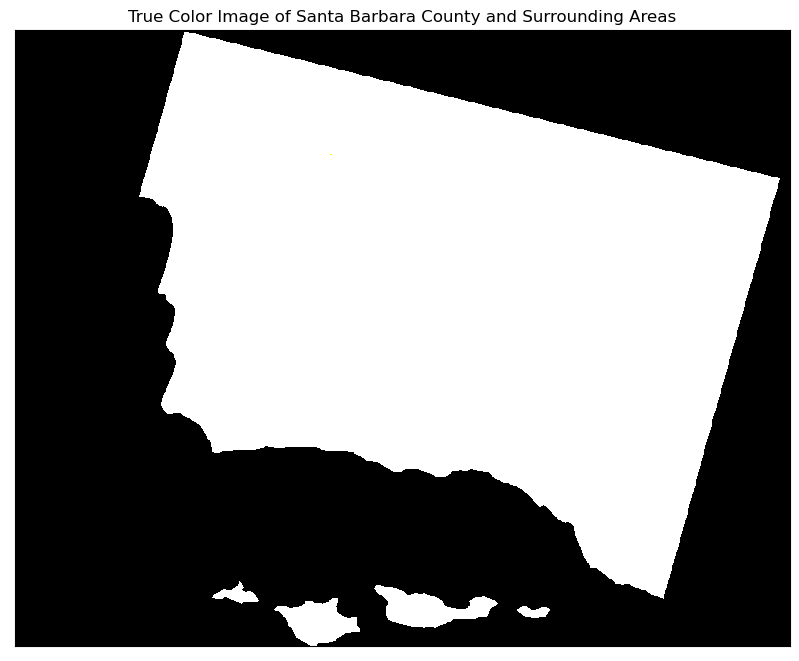

In [6]:
# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Create a true color (RGB) image of Santa Barbara County
# Select the "red", "green", and "blue" variables  
landsat[['red', 'green', 'blue']].to_array().plot.imshow()

# Add title
ax.set_title("True Color Image of Santa Barbara County and Surrounding Areas")  

# Remove axes ticks
ax.set_xticks([])  
ax.set_yticks([])  

# Remove axes labels
ax.set_xlabel("")  
ax.set_ylabel("") 

plt.show()

Yikes! We have a white map, with no colors! Did we do something wrong?

Lets try setting the robust parameter to true and see if that helps.

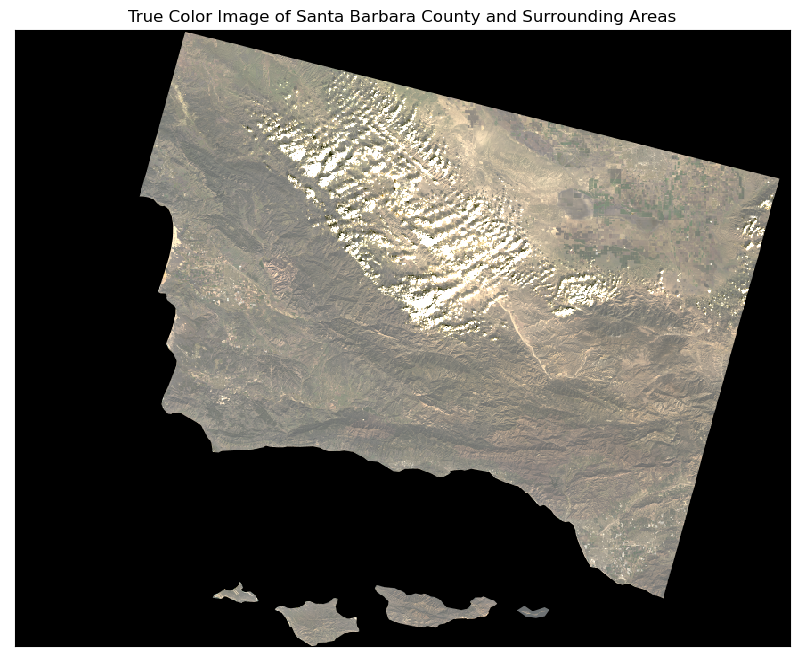

In [7]:
# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Create a true color (RGB) image of Santa Barbara County
# Set the `robust` parameter to `True`
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

# Add title
ax.set_title("True Color Image of Santa Barbara County and Surrounding Areas")  

# Remove axes ticks
ax.set_xticks([])  
ax.set_yticks([])  

# Remove axes labels
ax.set_xlabel("")  
ax.set_ylabel("") 

plt.show()

That is much better!

The cloud RGB values are outliers compared to the values of the rest of the image. This causes the rest of the values to be squished when plotting which results in not being able to see anything in the resulting image. The robust parameter pulls weight away from these outliers, allowing the rest of the image to scale properly.

## False Color Image

The purpose of a false color image is to assign bands of light not visible to the human eye to the visible spectrum, where we can create an image that allows a burn scar to stand out amongst healthy vegetation. Using near infrared (NIR) bands of light is an excellent way to map vegetation because healthy vegeation tends to reflect higher levels of NIR bands than dead or dying vegetation. In this false color image we have assigned the shortwave infrared band to the red channel, which means bare ground and dead vegetation is going to appear as red on our map. We have assigned the NIR band to the green channel, which means healthy vegetation will appear as green on our map.

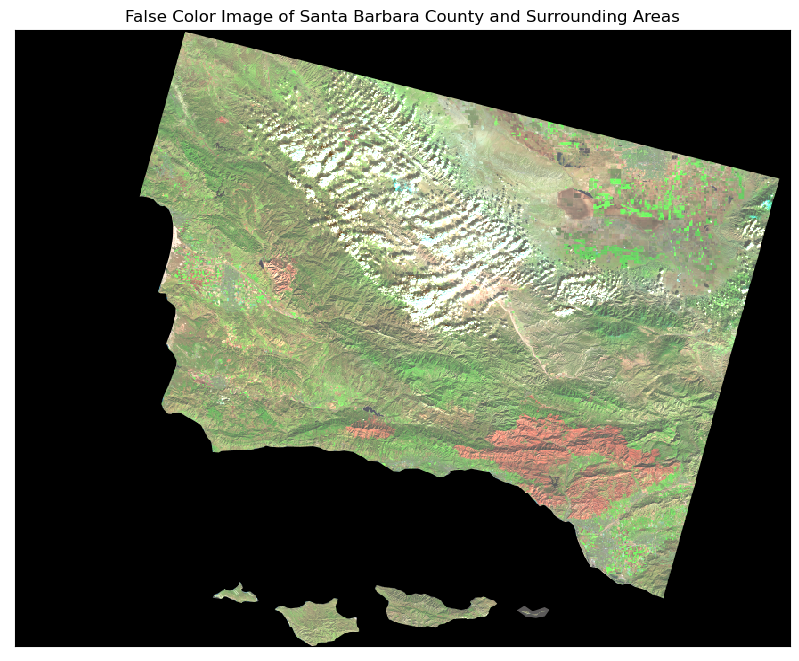

In [8]:
# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Create a false color image of Santa Barbara County
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust=True)

# Add title
ax.set_title("False Color Image of Santa Barbara County and Surrounding Areas")  

# Remove axes ticks
ax.set_xticks([])  
ax.set_yticks([])  

# Remove axes labels
ax.set_xlabel("")  
ax.set_ylabel("") 

plt.show()

## False Color Map of the 2017 Thomas Fire

Now that we have a false color image of Santa Barbara county and the surrounding area, we need to add the boundary of the 2017 Thomas Fire to see if it lines up with what we think the false color image is telling us about where there is burned vegetation.

But first we must check that the CRS of the thomas fire shapefile matches the CRS of the `landsat` data.

In [9]:
# Confirm the CRS of the data match
if thomas_fire.crs == landsat.rio.crs:
    print("The CRS match.")
else:
    thomas_fire = thomas_fire.to_crs(landsat.rio.crs)
    print("The CRS match.")

The CRS match.


Now that we have confirmed the CRS match, we can add the Thomas Fire boundary to our false color image.

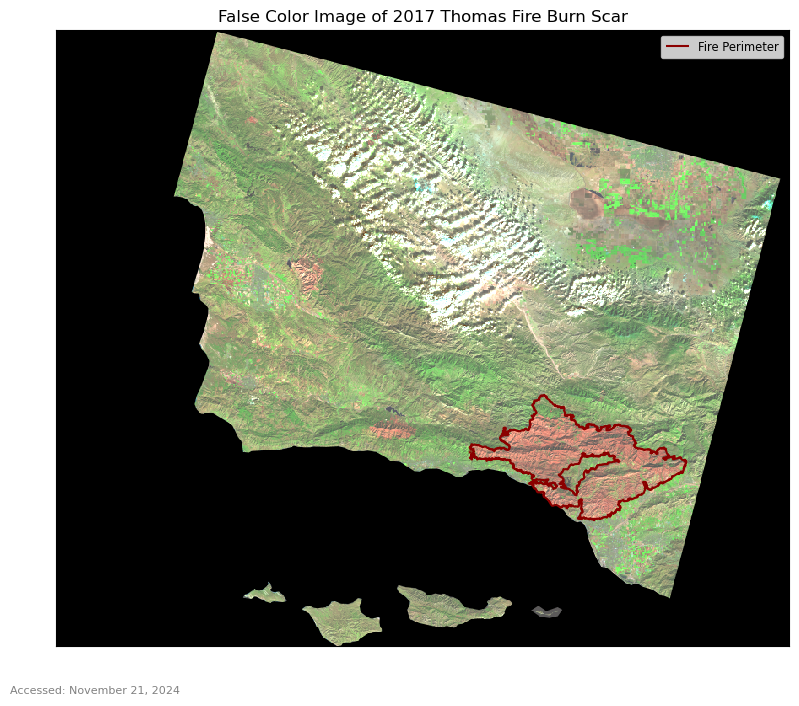

In [10]:
# Plot
fig, ax = plt.subplots(figsize=(10, 8))  

# Add landsat data
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(ax=ax,
                                                           robust=True)

# Add Thomas Fire Perimeter
thomas_fire.geometry.boundary.plot(ax=ax,
                                   color='darkred',
                                   linewidth=1.5,
                                   label="Fire Perimeter")

# Add legend
ax.legend(fontsize='small')

# Add title
ax.set_title("False Color Image of 2017 Thomas Fire Burn Scar")  

# Remove axes ticks
ax.set_xticks([])  
ax.set_yticks([])  

# Remove axes labels
ax.set_xlabel("")  
ax.set_ylabel("") 

# Add access date
plt.figtext(0.1, 0.05, 
            "Accessed: November 21, 2024", 
            fontsize=8, 
            color="grey")

plt.show()

## Visualizing AQI during the 2017 Thomas Fire in Santa Barbara County

In the following analysis we will use Air Quality Index (AQI) from the Environmental Protection Agency (EPA) to visualize the impact on Santa Barbara County air quality by the 2017 Thomas Fire.

We first load the daily AQI data from 2017 and 2018 and combine the two data frames into a single dataframe. This will allow us to more easily visulaize our data. After we have combined our data frames, we can filter for Santa Barbara County and keep only the columns we need in our resulting data frame. 

In [11]:
# Read in data
aqi_17 = pd.read_csv('data/daily_aqi_by_county_2017.csv', 
                     index_col=['Date'],   # Set the index to be the `Date` column
                     parse_dates=['Date']) # Update the `Date` column to a `pandas.datetime` object
aqi_18 = pd.read_csv('data/daily_aqi_by_county_2018.csv',
                     index_col=['Date'],   
                     parse_dates=['Date'])

# Combine the `aqi_17` and `aqi_18` dataframes into a single dataframe
aqi = pd.concat([aqi_17, aqi_18])
       
# Simplify column names
aqi.columns = (aqi.columns
                  .str.lower()
                  .str.replace(' ','_')
              )

# Select data only from Santa Barbara County
aqi_sb = (aqi[aqi['county_name'] == 'Santa Barbara']
          # Remove the `state_name`, `county_name`, `state_code`, and `county_code` columns
          .drop(columns = ['state_name', 'county_name', 'state_code', 'county_code'])
         )

We can now calculate a 5 day rolling average of our air quality data in Santa Barbara County and add it as a new column in our `aqi_sb` data frame.

In [12]:
# Calculate AQI rolling average over 5 days and add to a new column
aqi_sb['five_day_average'] = aqi_sb['aqi'].rolling('5D').mean()

Create a plot of our AQI five day rolling average and the unmanipulated AQI.

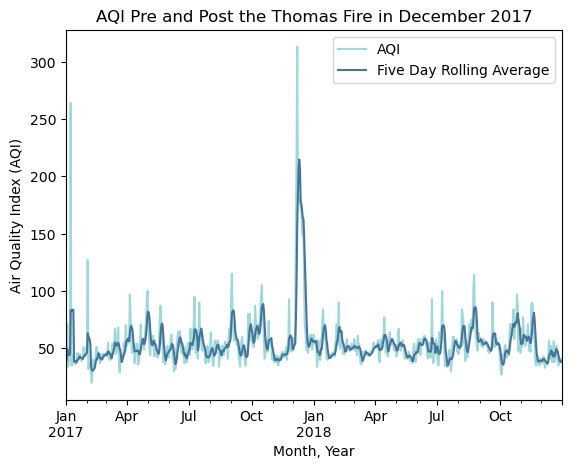

In [13]:
# Line plot 
(aqi_sb.plot(y=['aqi', 'five_day_average'],
            title ='AQI Pre and Post the Thomas Fire in December 2017',
            xlabel='Month, Year',
            ylabel='Air Quality Index (AQI)',        
            color = {'aqi':'#9ED8DB',
                     'five_day_average': '#467599'
                    }
           ).legend(['AQI','Five Day Rolling Average'])
)

Higher AQI indicates poor air quality and we can clearly see a spike in AQI during December 2017 when the Thomas Fire was burning. The five day rolling average helps to smooth our data and eliminate the showiness of outlier AQI data points. Even with this smoothing, there is a distinguishable spike in AQI in December 2017. This figure also indicates there was not a long term impact to AQI after the Thomas Fire was extinguished. 

## References

CalFire. Updated April 2023. [https://www.fire.ca.gov/what-we-do/fire-resource-assessment-program/fire-perimeters](https://www.fire.ca.gov/what-we-do/fire-resource-assessment-program/fire-perimeters). Accessed: November 16, 2024

Landsat Collection 2 Level-2, Microsoft Open Source, Matt McFarland, Rob Emanuele, Dan Morris, & Tom Augspurger. (2022). microsoft/PlanetaryComputer: October 2022 (2022.10.28). Zenodo. [https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2). Accessed: November 16, 2024

U.S. Enivornmental Protection Agency. (2024). Air Quality Index Daily Values Report: July 2024 (2024.07.23). [https://www.epa.gov/outdoor-air-quality-data/air-quality-index-daily-values-report](https://www.epa.gov/outdoor-air-quality-data/air-quality-index-daily-values-report). Accessed: October 22, 2024